In [1]:
import numpy as np
import pandas as pd
import pickle
import json
import seaborn as sb
import numpy as np
from collections import defaultdict
import sys
import chardet
import matplotlib.pyplot as plt
%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Distribution of predictability values

In [2]:
def read_in_pred_files(pred_map_filepaths):
    pos_pred_maps = []
    for predictor, filepath in pred_map_filepaths:
        with open(filepath) as f:
            pos_pred_maps.append((predictor,json.load(f)))
    return pos_pred_maps

In [3]:
def text_words_predictions(pos_pred_map,predictor,text_words):
    
    pred_values = defaultdict(list)
    
    for text, words in text_words.items():
        text_predictions = pos_pred_map[str(text-1)]
        for i, word in enumerate(words,1):
            if str(i) in text_predictions.keys(): # some words are missing from cloze task in PROVO
                word_predictions = text_predictions[str(i)]
                pred_value = 0.0
                if word in word_predictions.keys():
                    pred_value = word_predictions[word]
                if pred_value != 1.025: # to exclude mistaken value from cloze data
                    pred_values['text_word'].append(word)
                    pred_values['prediction'].append(pred_value)
                    pred_values['predictor'].append(predictor)
                
    return pred_values

In [4]:
def compute_frequency_predictions(predictions):
    
    pred_values, counts, predictors = [],[],[]
    
    for predictor in set(predictions['predictor']):
        pred_value_counts = defaultdict(int)
        for prediction, a_predictor in zip(predictions['prediction'],predictions['predictor']):
            if predictor == a_predictor:
                pred_value_counts[prediction] += 1
        pred_values.extend(pred_value_counts.keys())
        counts.extend(pred_value_counts.values())

        for pred_value in range(len(pred_value_counts.keys())): 
            predictors.append(predictor)

        assert len(pred_values) == len(counts) == len(predictors), print(len(pred_values),len(counts),len(predictors))

        pred_value_counts_col = {'predictability': pred_values,
                                 'counts': counts,
                                 'proportion': [round(value/len(words_in_text),3) for value in counts],
                                 'predictor': predictors}
    return pred_value_counts_col

In [5]:
# read in stimulus (true words)
stimulus_filepath = '../data/predictability/Provo_Corpus-Predictability_Norms.csv'
# encoding = chardet.detect(open(stimulus_filepath, "rb").read())['encoding']
encoding = "ISO-8859-1"
data = pd.read_csv(stimulus_filepath, encoding=encoding)

words_in_text = defaultdict(list)
word_ids_in_text = defaultdict(list)
for word_info, rows in data.groupby(['Text_ID','Word_Number']):
    words_in_text[int(word_info[0])].append(rows['Word'].tolist()[0])
    word_ids_in_text[int(word_info[0])].append(word_info[-1])

In [6]:
# read in predictions
pred_map_filepaths_target = [('cloze','../data/predictability/prediction_map_Provo_Corpus_cloze_continuous reading_english.json'),
                              ('GPT2', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topktarget_word.json')]
pred_map_targets = read_in_pred_files(pred_map_filepaths_target)

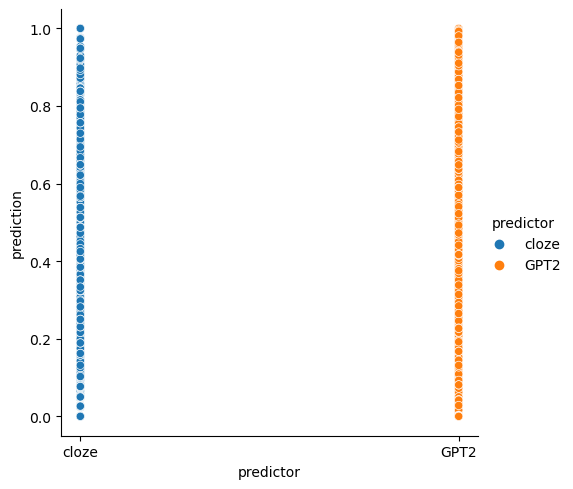

In [7]:
# compare target predictions from cloze and gtp2
target_predictions = defaultdict(list)

for predictor, pred_map in pred_map_targets:
    pred_values = text_words_predictions(pred_map,predictor,words_in_text)
    target_predictions['prediction'].extend(pred_values['prediction'])
    target_predictions['text_word'].extend(pred_values['text_word'])
    target_predictions['predictor'].extend(pred_values['predictor'])
    
pred_value_counts_df = pd.DataFrame.from_dict(target_predictions)
pred_value_counts_df.to_csv('../data/predictability/predictions_text_words.csv',sep='\t', index=False)

sb.relplot(data=target_predictions, x = 'predictor', y = 'prediction', hue = 'predictor', kind = 'scatter')

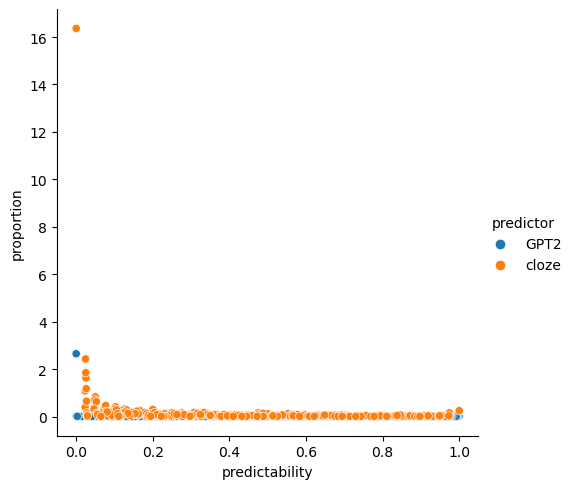

In [8]:
# count pred values in each predictor only including the predictability of target words (words in text) AND taking the pred value of word in text in GPT2
pred_value_counts_col = compute_frequency_predictions(target_predictions)
pred_value_counts_df = pd.DataFrame.from_dict(pred_value_counts_col)
pred_value_counts_df.to_csv('../data/predictability/predictions_distribution.csv',sep='\t', index=False)
sb.relplot(data=pred_value_counts_col, x = 'predictability', y = 'proportion', hue = 'predictor', kind = 'scatter')

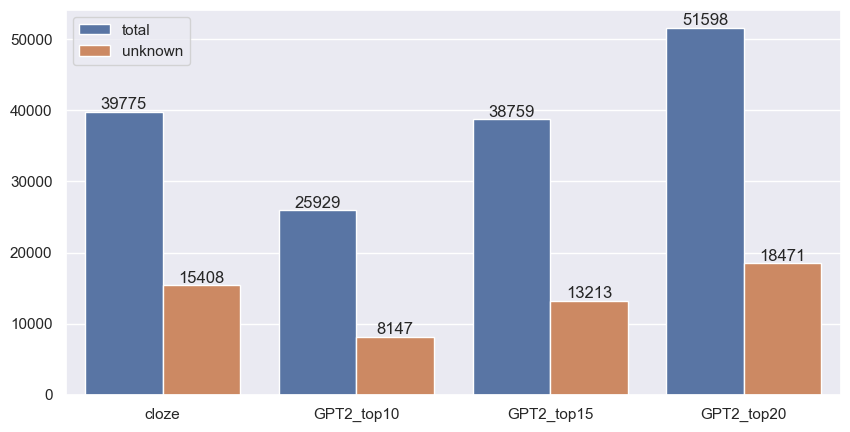

In [9]:
# proportion of known and unknown predicted tokens in relation to model lexicon & of known target words
map_filepaths = [('cloze','../data/predictability/prediction_map_Provo_Corpus_cloze_continuous reading_english.json'),
                ('GPT2_top10', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk10.json'),
                ('GPT2_top15', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk15.json'),
                ('GPT2_top20', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk20.json')]
unknown_map_filepaths = [('cloze','../data/predictability/prediction_map_Provo_Corpus_cloze_continuous reading_english_unknown.json'),
                      ('GPT2_top10', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk10_unknown.json'),
                      ('GPT2_top15', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk15_unknown.json'),
                      ('GPT2_top20', '../data/predictability/prediction_map_Provo_Corpus_language model_continuous reading_english_topk20_unknown.json')]

pos_pred_maps = read_in_pred_files(map_filepaths)
pos_pred_maps_unknown = read_in_pred_files(unknown_map_filepaths)

predictors, counts, category = [],[],[]

for all_map, unknown_map in zip(pos_pred_maps,pos_pred_maps_unknown):  
    counts.append(sum([len(words.keys()) for text, info in all_map[1].items() if info for idx, words in info.items()]))
    counts.append(sum([len(words.keys()) for text, info in unknown_map[1].items() if info for idx, words in info.items()]))
    predictors.extend([all_map[0],unknown_map[0]])
    category.extend(['total', 'unknown'])
    
assert len(predictors) == len(counts) == len(category)

sb.set(rc={'figure.figsize': (10,5)})
ax = sb.barplot(x=predictors, y=counts, hue=category)
for i in ax.containers:
    ax.bar_label(i,)

# Word prediction accuracy

In [10]:
# get predictions from cloze
predicted_words_cloze = [list(predictions.keys()) for pos_text in pos_pred_maps[0][1].values() for predictions in pos_text.values()]

# get predictions from gpt2
predicted_words_gpt2 = dict()
for topk in pos_pred_maps[1:]:
    pred_words = list()
    for text_id, words in words_in_text.items():
        text_predictions = topk[1][str(text_id-1)]
        for i, word in enumerate(words,1):
            if str(i) in text_predictions.keys(): # some words are missing from cloze task in PROVO
                word_predictions = text_predictions[str(i)]
                pred_words.append(list(word_predictions.keys()))
    predicted_words_gpt2[topk[0]] = pred_words
                
#     pred_words = [list(predictions.keys()) for pos_text in topk[1].values() for predictions in pos_text.values()]
assert len(predicted_words_cloze) == len(predicted_words_gpt2['GPT2_top10']), print(len(predicted_words_cloze), len(predicted_words_gpt2['GPT2_top10']))

In [11]:
# save predictions for each text word and whether prediction is right

words_in_text_list, word_ids_in_text_list = [],[]
for text_word_ids, text_words in zip(word_ids_in_text.values(), words_in_text.values()):
    words_in_text_list.extend(text_words)
    word_ids_in_text_list.extend(text_word_ids)

for topk, gtp2_predictions in predicted_words_gpt2.items():
    
    accuracy_info = {'word_id': list(),
                    'word': list(),
                    'cloze_predictions': list(),
                    'gpt2_predictions' : list(),
                    'cloze_acc': list(),
                    'gpt2_acc': list()}

    for word_id, word, predictions in zip(word_ids_in_text_list, words_in_text_list, predicted_words_cloze):
        accuracy_info['word'].append(word)
        accuracy_info['word_id'].append(word_id)
        top_k = topk.replace('GPT2_top','')
        accuracy_info['cloze_predictions'].append(predictions[:int(top_k)+1])
        if word in predictions[:int(top_k)+1]:
            accuracy_info['cloze_acc'].append(1)
        else:
            accuracy_info['cloze_acc'].append(0)
            
    for word_id, word, predictions in zip(word_ids_in_text_list, words_in_text_list, gtp2_predictions):
        accuracy_info['gpt2_predictions'].append(predictions)
        if word in predictions:
            accuracy_info['gpt2_acc'].append(1)
        else:
            accuracy_info['gpt2_acc'].append(0)

    df = pd.DataFrame.from_dict(accuracy_info)
    df.to_csv(f'../data/predictability/accuracy_cloze_{topk}.csv', sep='\t', index=False)

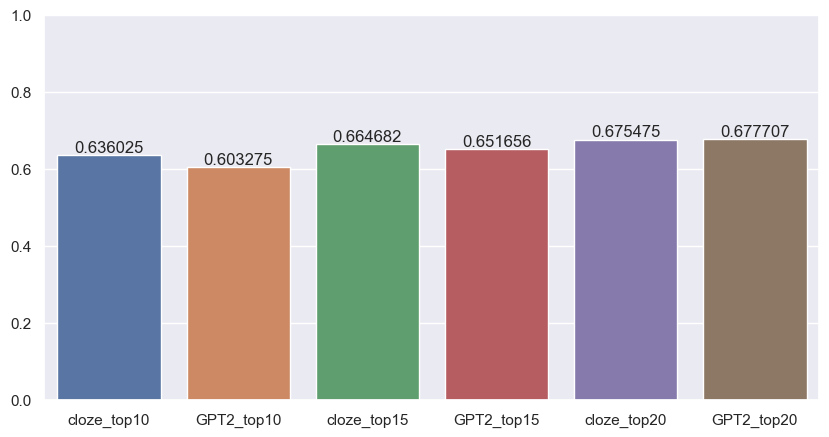

In [12]:
# accuracy scores - seaborn figure
# TODO plot cloze top k predictions

accuracy_scores = defaultdict(list)

for topk, preds in pos_pred_maps[1:]:
    
    top_k = topk.replace('GPT2_top','')
    df_accuracy = pd.read_csv(f'../data/predictability/accuracy_cloze_{topk}.csv', sep='\t')
    acc_cloze = sum(df_accuracy['cloze_acc'].tolist())/len(df_accuracy['cloze_acc'].tolist())
    accuracy_scores['predictor'].append(f'cloze_top{top_k}')
    accuracy_scores['accuracy'].append(acc_cloze)
    # if 'cloze' not in accuracy_scores['predictor']: 
    #     accuracy_scores['predictor'].append('cloze')
    #     accuracy_scores['accuracy'].append(acc_cloze)
    acc_gpt2 = sum(df_accuracy['gpt2_acc'].tolist())/len(df_accuracy['gpt2_acc'].tolist())
    accuracy_scores['predictor'].append(topk)
    accuracy_scores['accuracy'].append(acc_gpt2)
    
sb.set(rc={'figure.figsize': (10,5)})
ax = sb.barplot(x=accuracy_scores['predictor'],y=accuracy_scores['accuracy'])
ax.set(ylim=(0.0, 1.0))
for i in ax.containers:
    ax.bar_label(i,)

In [39]:
# # refixations
# refixations = first_pass.groupby(['foveal word index']).filter(lambda x:len(x)>1)

# # second fixation
# second_fixations = first_pass.loc[refixations.groupby(['foveal word index']).apply(lambda x: x.index[1]).values,:][['foveal word','foveal word index','fixation duration']]

# # saccade type counts
# saccade_type_counts = sim_results['saccade type'].value_counts()

# # total viewing time for each token
# sum_fixation_duration = sim_results.groupby(['foveal word index'])[['fixation duration']].sum()